In [1]:
%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
linearMesh = uw.mesh.FeMesh_Cartesian(('Q2','dPc1'), (64,64), (0.,0.), (1.,1.))

In [3]:
constantMesh = linearMesh.subMesh

In [4]:
velocityField = uw.fevariable.FeVariable(linearMesh,2)
velocityField.data[:] = (0.,0.)

In [5]:
pressureField = uw.fevariable.FeVariable(constantMesh,1)
pressureField.data[:] = 0.

In [6]:
# setup freeslip
IWalls = linearMesh.specialSets["MinI_VertexSet"] + linearMesh.specialSets["MaxI_VertexSet"]
JWalls = linearMesh.specialSets["MinJ_VertexSet"] + linearMesh.specialSets["MaxJ_VertexSet"]
freeslip = uw.conditions.DirichletCondition(velocityField, (IWalls, JWalls))

In [7]:
# setup analytic functions
#solA = fn.analytic.SolCx()
# solA = fn.analytic.SolKx()
solA = fn.analytic.SolKx(1.0, 3.333, 2, 0.7)

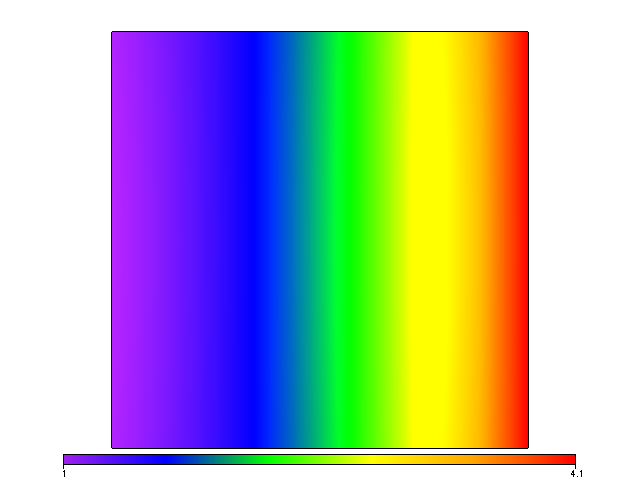

In [8]:
# get eta function from solA and take a look
eta = plt.Figure()
eta.Surface(solA.viscosityFn,linearMesh)
eta.show()

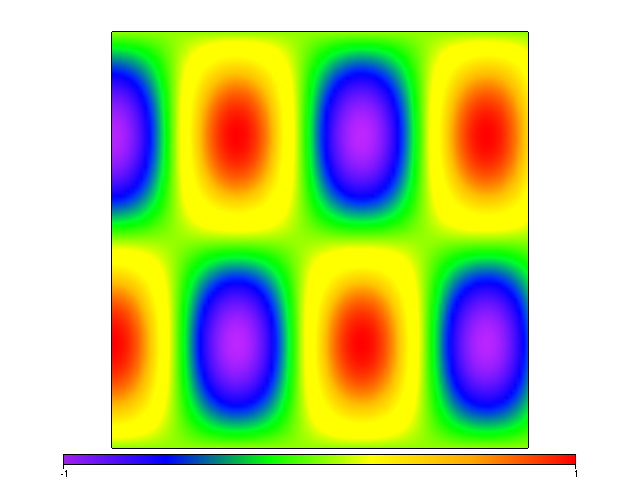

In [9]:
# grab the body force from SolA and take a look at vertical component
force = plt.Figure()
force.Surface(solA.bodyForceFn[1], linearMesh)
force.show()

In [10]:
solA.bodyForceFn[1].evaluate((1.0,0.75))


array([[ 0.50090663]])

In [11]:
# setup our stokes guy
stokesSystem = uw.systems.Stokes(velocityField,pressureField,solA.viscosityFn,solA.bodyForceFn,conditions=[freeslip,], rtolerance=1.e-5)

In [12]:
# lets solve
stokesSystem.solve()

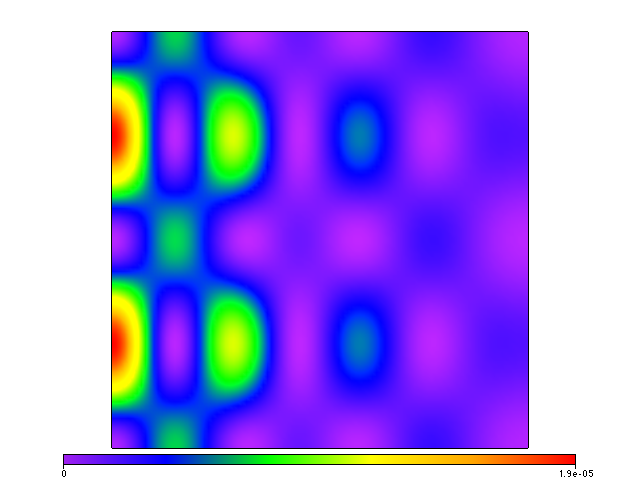

In [13]:
# lets check FEM solution
velMag = plt.Figure()
velMag.Surface(fn.math.dot(velocityField,velocityField), linearMesh)
velMag.show()

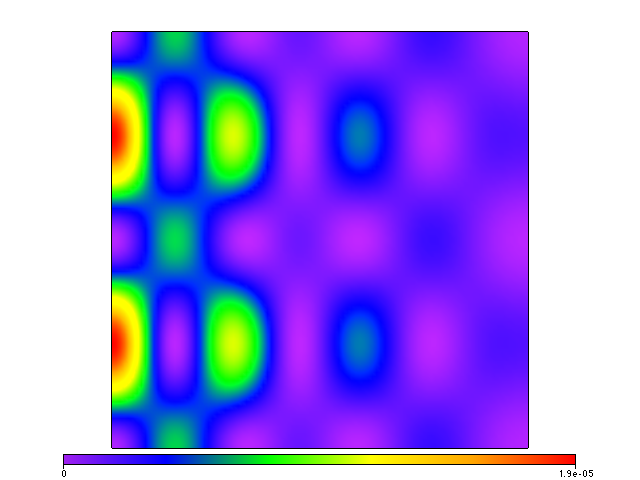

In [14]:
# and analytic
velMagA = plt.Figure()
velMagA.Surface(fn.math.dot(solA.velocityFn,solA.velocityFn), linearMesh)
velMagA.show()

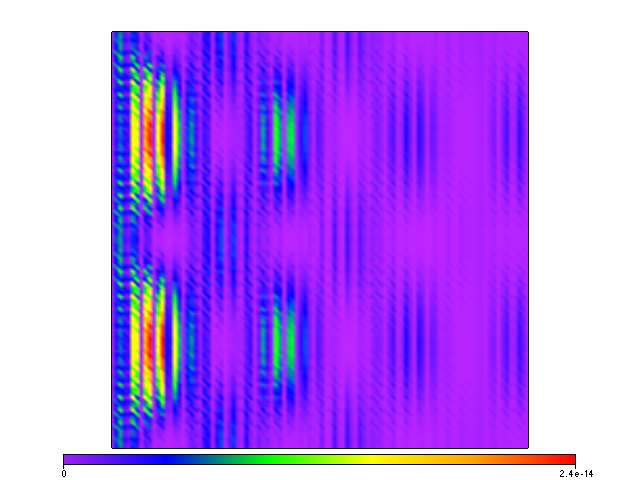

In [15]:
# and difference
velDiff = plt.Figure()
velDiff.Surface(fn.math.dot(solA.velocityFn - velocityField,solA.velocityFn - velocityField), linearMesh)
velDiff.show()

In [16]:
# rms
squared = uw.utils.Integral(fn.math.dot(solA.velocityFn-velocityField,solA.velocityFn-velocityField), linearMesh)
area = uw.utils.Integral(1.,linearMesh)
math.sqrt(squared.integrate()[0]/area.integrate()[0])

3.815171208368349e-08

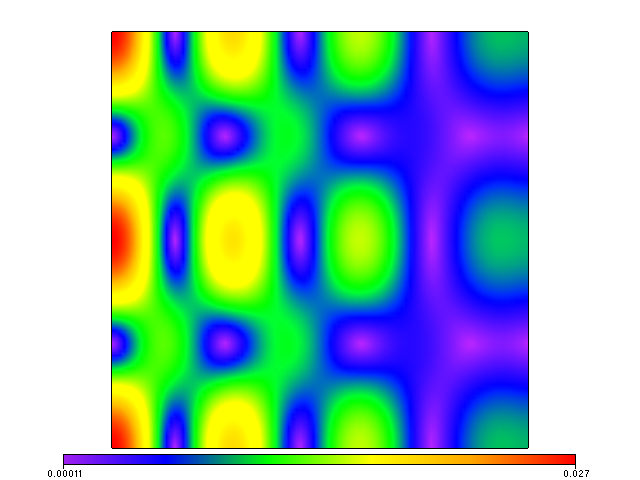

In [17]:
# let's look at strainrate invariant
invfigA = plt.Figure()
invfuncA = fn.tensor.second_invariant(solA.strainRateFn)
invfigA.Surface( invfuncA, linearMesh )
invfigA.show()

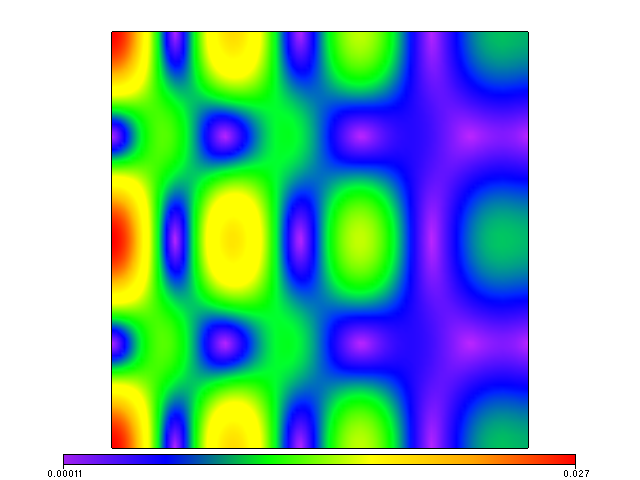

In [18]:
# let's look at numeric strainrate invariant
invfig = plt.Figure()
invfunc = fn.tensor.second_invariant( 
                fn.tensor.deviatoric(
                    fn.tensor.symmetric ( 
                        velocityField.gradientFn )) )
invfig.Surface( invfunc, linearMesh )
invfig.show()

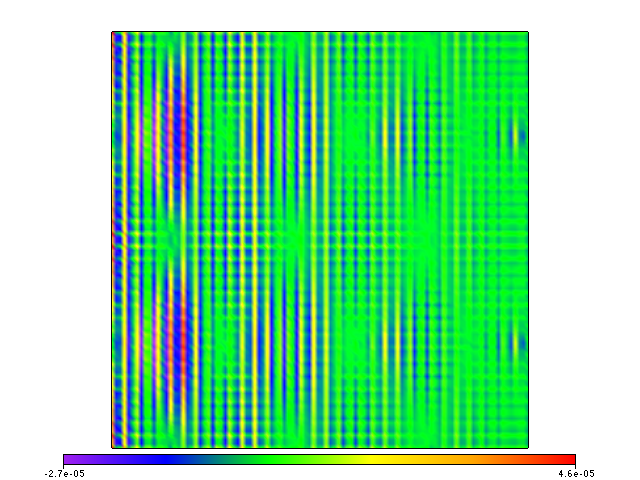

In [19]:
# and strainrate diff
srdiff = plt.Figure()
srdiffFunc = invfunc - invfuncA
srdiff.Surface( srdiffFunc, linearMesh)
srdiff.show()

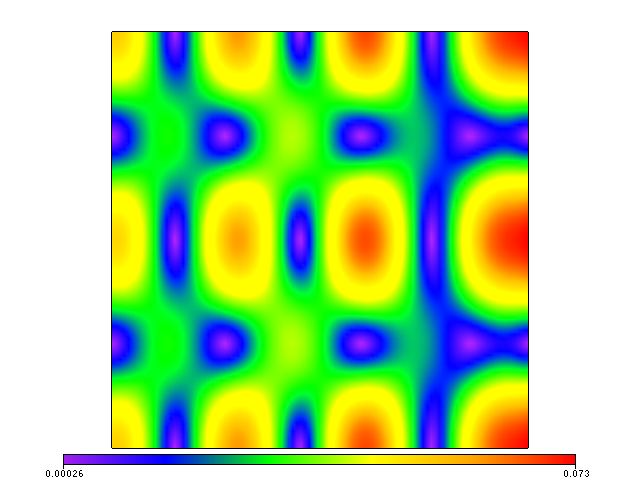

In [20]:
# and stress
stressFigA = plt.Figure()
stressFuncA = fn.tensor.second_invariant(fn.tensor.deviatoric(solA.stressFn))
stressFigA.Surface( stressFuncA, linearMesh)
stressFigA.show()

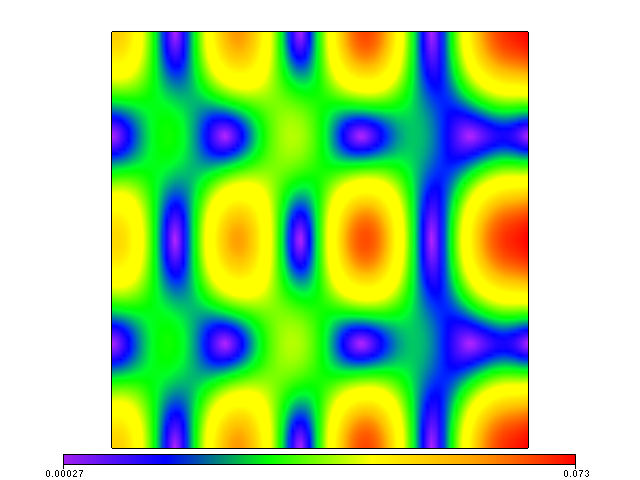

In [21]:
# numeric stress
stressFig = plt.Figure()
stressfunc = fn.tensor.second_invariant( 2.*solA.viscosityFn*fn.tensor.symmetric( velocityField.gradientFn ))
stressFig.Surface(stressfunc, linearMesh)
stressFig.show()

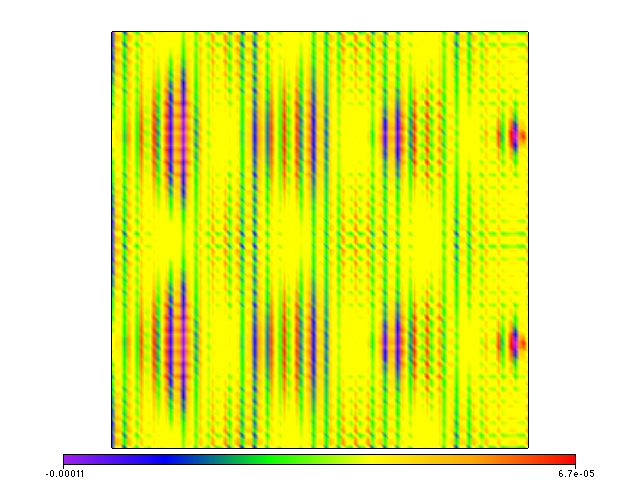

In [22]:
stressDiffFig = plt.Figure()
stressDifffunc = stressFuncA - stressfunc
stressDiffFig.Surface(stressDifffunc, linearMesh)
stressDiffFig.show()

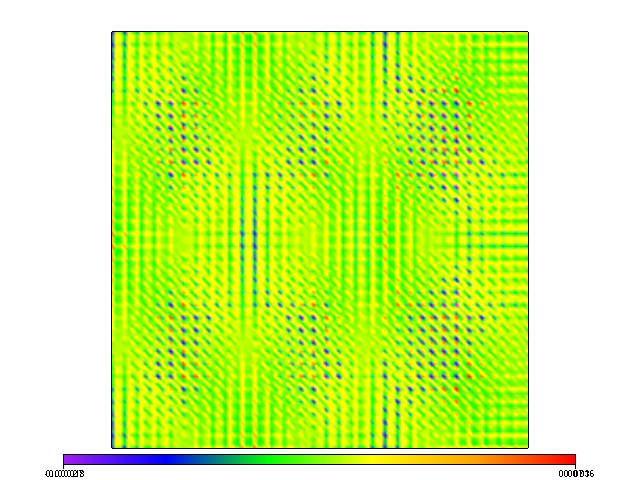

In [23]:
# numeric/analytic pressure

pressureFig = plt.Figure()
stressFig.Surface(pressureField - solA.pressureFn, linearMesh)
stressFig.show()

In [24]:
## Compute topography and see how that looks

stresstensorfunc =  2.*solA.viscosityFn*fn.tensor.symmetric( velocityField.gradientFn )
stresstensorfuncA = fn.tensor.deviatoric(solA.stressFn)

surface_deviatoric_stress = stresstensorfunc.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
surface_pressure = pressureField.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
surface_total_stress = surface_deviatoric_stress.T[1]-surface_pressure.T[0]

analytic_surface_deviatoric_stress = stresstensorfuncA.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
analytic_surface_pressure = solA.pressureFn.evaluate(linearMesh.specialSets["MinJ_VertexSet"])
analytic_surface_total_stress = analytic_surface_deviatoric_stress.T[1]-analytic_surface_pressure.T[0]

/usr/lib/pymodules/python2.7/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


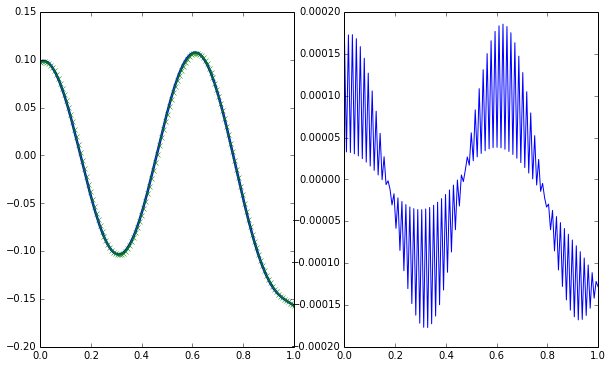

In [25]:

import matplotlib.pyplot as pyplot
from matplotlib import cm
import numpy as np

surface_points_X = linearMesh.data[linearMesh.specialSets["MinJ_VertexSet"].data].T[0]

figure, (plot1, plot2) = pyplot.subplots(1,2)
figure.set_size_inches(10,6)
plot1.plot(surface_points_X, surface_total_stress, linewidth=2.5)
plot1.plot(surface_points_X, analytic_surface_total_stress, marker='x', markersize=5.0)
plot2.plot(surface_points_X, (surface_total_stress-analytic_surface_total_stress))

figure.show()

In [26]:
# Global error measure

def rmsErr(F1, F2):
    """
    Find the rms error between two arrays
    """
    import numpy as np
    
    diff = np.sqrt(( F1-F2 )**2).sum()
    scale = 0.5 * np.sqrt(( F1 )**2).sum() + 0.5 * np.sqrt(( F2 )**2).sum()
    
    try:
        error = diff / scale
    except:
        print "Rms error not available"
        
    return error
        
        
rms_topo_err = rmsErr(analytic_surface_deviatoric_stress, surface_deviatoric_stress)
rms_pressure_err = rmsErr(pressureField.evaluate(linearMesh), solA.pressureFn.evaluate(linearMesh))
rms_velocity_err = rmsErr(fn.math.dot(velocityField,velocityField).evaluate(linearMesh), fn.math.dot(solA.velocityFn,solA.velocityFn).evaluate(linearMesh))

In [27]:
print "Topography error - ", rms_topo_err*100, " %"
print "Pressure error - ", rms_pressure_err*100," %"
print "Velocity (magnitude) error - ", rms_velocity_err*100, " %"

Topography error -  0.115623575245  %
Pressure error -  0.190023173664  %
Velocity (magnitude) error -  0.000511809106375  %
